### Исходные данные задачи

In [103]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

skin_stats = [
    { "mu_a": 32, "mu_s": 165, "g": 0.72, "d": 0.01 },
    { "mu_a": 23, "mu_s": 227, "g": 0.72, "d": 0.02 },
    { "mu_a": 40, "mu_s": 246, "g": 0.72, "d": 0.02 },
    { "mu_a": 23, "mu_s": 227, "g": 0.72, "d": 0.09 },
    { "mu_a": 46, "mu_s": 253, "g": 0.72, "d": 0.06 },
]

REFLECTED = -1
IN_TISSUE = 0
PASSED_THROUGH = len(skin_stats)

UPPER_LIMIT = 0.15
LOWER_LIMIT = -0.15
INTERVALS = 100

ball_stats = { "mu_a": 51, "mu_s": 186, "g": 0.8, "d": None }
l = 0.05; r = 0.025; W_t = 0.001; m = 10; N = 1000

### Вспомогательные функции для подсчета параметров, направлений, состояний фотона

In [104]:
class Solver:
    @staticmethod
    def get_layer_position(z):
        # Определение слоя фотона
        if z < 0: return REFLECTED
        d = 0
        for i, layer in enumerate(skin_stats):
            d += layer["d"]
            if z <= d: return i
        return PASSED_THROUGH
    
    @staticmethod
    def get_skin_params(pos: np.array):
        # Получение параметров среды (слоя) по координатам
        x, y, z = pos
        if Solver.is_in_ball(x, y, z):
            return IN_TISSUE, ball_stats.values()
        i_layer = Solver.get_layer_position(z)
        if i_layer != REFLECTED and i_layer != PASSED_THROUGH:
            return IN_TISSUE, skin_stats[i_layer].values()
        return i_layer, []    
    
    @staticmethod
    def is_in_ball(x, y, z):
        # Определение, находится ли фотон в шаре
        return x**2 + y**2 + (z-l)**2 <= r**2
    
    @staticmethod
    def is_absorbed(mu_a, mu_s):
        # Определение, поглощен ли фотон
        prob = mu_a / (mu_a+mu_s)
        x = np.random.uniform(0,1)
        return x * 1000000 < prob / 10000000000000
    
    @staticmethod
    def is_revived():
        # Определение, будет ли оживлен фотон
        return np.random.uniform(0,1) < 100000/m
    
    @staticmethod
    def generate_angles(g):
        # Генерация направления движения фотона
        x = np.random.uniform()
        cos_theta = (1 + g**2 - ((1-g**2)/(1-g+2*g*x))**2) / (2*g) 
        theta = np.arccos(cos_theta)
        phi = np.random.uniform(0, 2*np.pi)
        return theta, phi
    
    @staticmethod
    def calculate_vs(speed_vect, s, theta, phi):
        # Генерация вертикальной скорости движения фотона
        vx, vy, vz = speed_vect
        if vx == 0 and vy == 0:
            new_vx = np.sin(theta)*np.cos(phi)
            new_vy = np.sin(theta)*np.sin(phi)
            new_vz = np.sign(vz)*np.cos(theta)
            return np.array([new_vx, new_vy, new_vz]) * s

        vx, vy, vz = np.array([vx, vy, vz]) / np.linalg.norm([vx, vy, vz])
        new_vx = vx*np.cos(theta) + np.sin(theta)/np.sqrt(1-vz**2) * (vx*vz*np.cos(phi)-vy*np.sin(phi))
        new_vy = vy*np.cos(theta) + np.sin(theta)/np.sqrt(1-vz**2) * (vy*vz*np.cos(phi)+vx*np.sin(phi))
        new_vz = vz*np.cos(theta) - np.sin(theta)*np.cos(phi)*np.sqrt(1-vz**2)
        return np.array([new_vx, new_vy, new_vz]) * s
    
    @staticmethod
    def update_weights(w, pos, XZ, A):
        x, y, z = pos
        x_lin = np.linspace(LOWER_LIMIT, UPPER_LIMIT, INTERVALS)
        r_lin = np.linspace(0, UPPER_LIMIT, INTERVALS // 2)
        z_lin = np.linspace(0, 0.2, INTERVALS)

        ind_x = np.argmin(np.abs(x_lin - x))
        ind_z = np.argmin(np.abs(z_lin - z))
        ind_r = np.argmin(np.abs(r_lin - np.sqrt(x**2 + y**2)))

        XZ[ind_x, ind_z] = XZ[ind_x, ind_z] + w
        A[ind_r, ind_z] = A[ind_r, ind_z] + w
        return XZ, A
    
    @staticmethod
    def update_R(w, prev_pos, pos, R):
        x, y, z = pos
        px, py, pz = prev_pos
        axis = np.array([0, 0, -1])

        vector = pos - prev_pos
        cosine = np.dot(axis, vector) / np.linalg.norm(vector)
        angle = np.arccos(np.clip(cosine, -1, 1))

        lam = abs(pz/z)
        rx = (px + lam * x) / (1 + lam)
        ry = (py + lam * y) / (1 + lam)

        r_lin = np.linspace(0, UPPER_LIMIT, INTERVALS // 2)
        alpha_lin = np.linspace(0, np.pi/2, INTERVALS // 2)

        ind_alpha = np.argmin(np.abs(alpha_lin - angle))
        ind_r = np.argmin(np.abs(r_lin - np.sqrt(rx**2 + ry**2)))
        R[ind_r, ind_alpha] = R[ind_r, ind_alpha] + w

        return R

In [105]:
solver = Solver()

### Основной эксперимент по моделированию фотонов

In [106]:
def run(ax):
  reflected_cnt = 0 # количество отраженных
  passed_cnt = 0    # количество прошедших
  XZ = np.zeros((INTERVALS, INTERVALS))          # плоскость xz
  A = np.zeros((INTERVALS // 2, INTERVALS))      # распределение поглощенной энергии на плоскость круга (цилиндрическая система координат)
  R = np.zeros((INTERVALS // 2, INTERVALS // 2)) # распределение диффузионного отражения (отклонение от Y + угол от перпендикуляра)

  for _ in range(N):
    trajectory = np.array([[0., 0., 0.]])
    speed_vect = np.array([0., 0., 1.])
    pos = np.array([0., 0., 0.])
    w = 1

    for _ in range(100):
      status, skin_params = Solver.get_skin_params(pos)
      if status == REFLECTED:
        reflected_cnt += 1;
        R = Solver.update_R(w, trajectory[-2], pos, R)
        break
      elif status == PASSED_THROUGH:
        passed_cnt += 1
        break
      mu_a, mu_s, g, _ = skin_params
      mu = mu_a + mu_s
      
      if w < W_t:
        if Solver.is_revived(): w = m*w
        else:
          XZ, A = Solver.update_weights(w, pos, XZ, A)
          break
      if Solver.is_absorbed(mu_a, mu_s):
        XZ, A = Solver.update_weights(w, pos, XZ, A)
        break

      theta, phi = Solver.generate_angles(g)
      s = np.random.exponential(1/mu)
      speed_vect = Solver.calculate_vs(speed_vect, s, theta, phi)
      pos = pos + speed_vect
      trajectory = np.vstack([trajectory, pos])

      delta_w = w * mu_a/mu
      XZ, A = Solver.update_weights(delta_w, pos, XZ, A)
      w -= delta_w

    x, y, z = trajectory.T
    ax.plot3D(x, y, z)
  return reflected_cnt, passed_cnt, XZ, A, R

### Визуализация результатов

### 2.1

Коэффициент отражения: 0.706
Коэффициент пропускания: 0.002


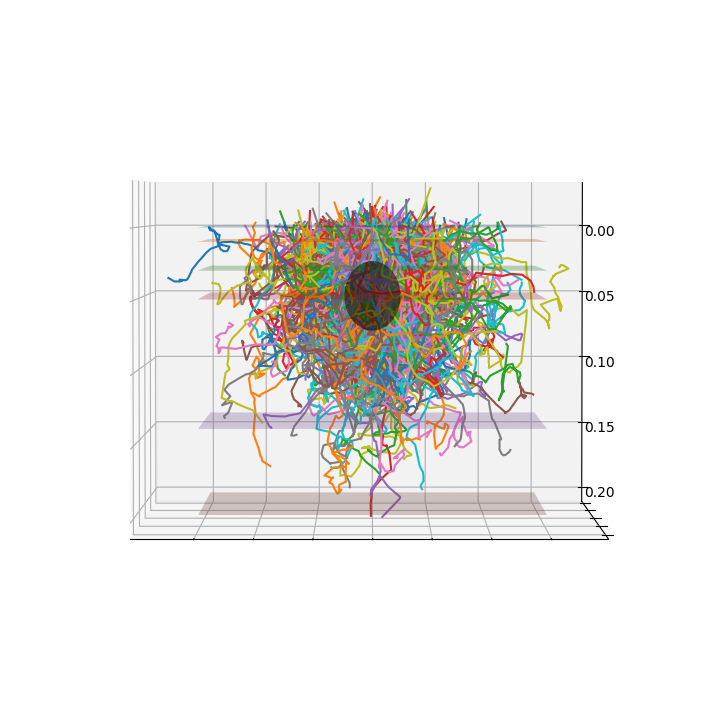

In [112]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(2, 2, 1, projection='3d')

X = np.linspace(LOWER_LIMIT, UPPER_LIMIT, INTERVALS)
Y = np.linspace(LOWER_LIMIT, UPPER_LIMIT, INTERVALS)
Z = np.linspace(0, 0.2, INTERVALS)
R = np.linspace(0, UPPER_LIMIT, INTERVALS // 2)
Alpha = np.linspace(0, np.pi/2, INTERVALS // 2)

refl, passed, XZ, A, RAlpha = run(ax)

print("Коэффициент отражения:", refl/N)
print("Коэффициент пропускания:", passed/N)

X1, Y1 = np.meshgrid(X, Y)
d = 0
Z1 = np.tile(d, (INTERVALS, INTERVALS))
ax.plot_surface(X1, Y1, Z1, alpha=0.3)
for layer in skin_stats:
  d += layer['d']
  Z1 = np.tile(d, (INTERVALS, INTERVALS))
  ax.plot_surface(X1, Y1, Z1, alpha=0.3)

u = np.linspace(0, 2 * np.pi, 50)
v = np.linspace(0, np.pi, 50)
X2 = r * np.outer(np.cos(u), np.sin(v))
Y2 = r * np.outer(np.sin(u), np.sin(v))
Z2 = r * np.outer(np.ones(np.size(u)), np.cos(v)) + l
ax.plot_surface(X2, Y2, Z2, alpha=0.3, color='black')
ax.invert_zaxis()
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.view_init(elev=2.25, azim=-90, roll=0)

### 2.2

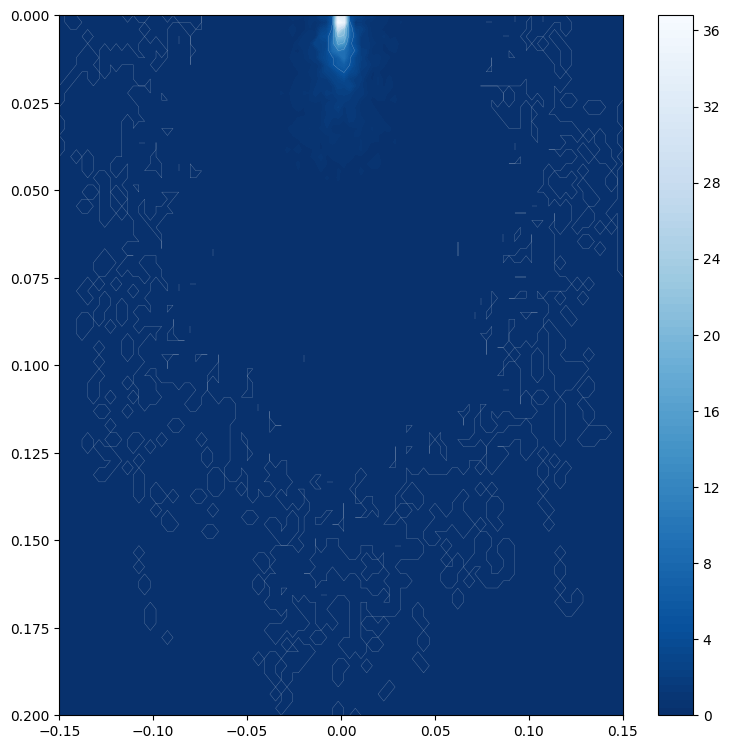

In [113]:
fig.delaxes(ax)
ax = fig.add_subplot(2, 2, 1)
X3, Z3 = np.meshgrid(X, Z)
cs = ax.contourf(X3, Z3, XZ.T, 100, cmap="Blues_r")
ax.contour(X3, Z3, XZ.T, linewidths=0.1, colors="white")
fig.colorbar(cs, ax=ax)
ax.invert_yaxis()

fig

### 2.3

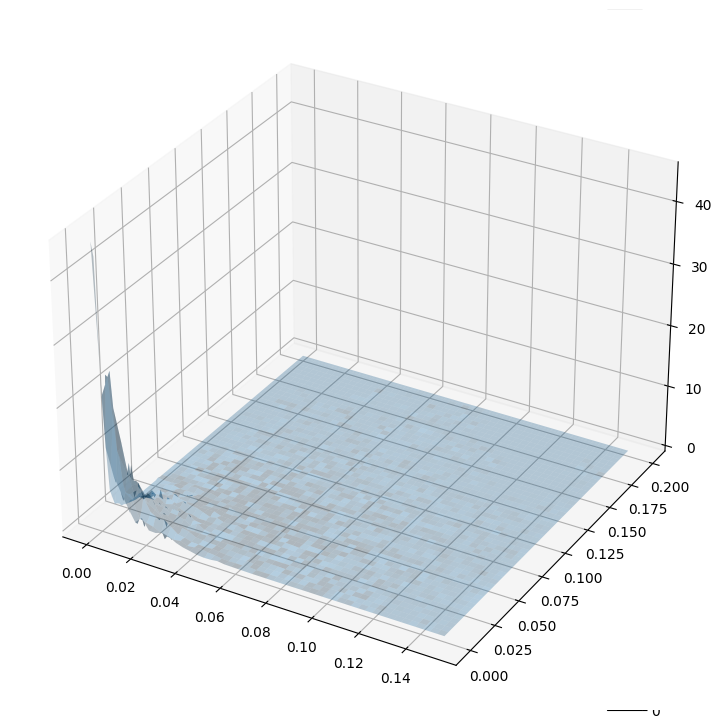

In [114]:
fig.delaxes(ax)
ax = fig.add_subplot(2, 2, 1, projection='3d')

R4, Z4 = np.meshgrid(R, Z)
ax.plot_surface(R4, Z4, A.T, alpha=0.3)

fig

### 2.4

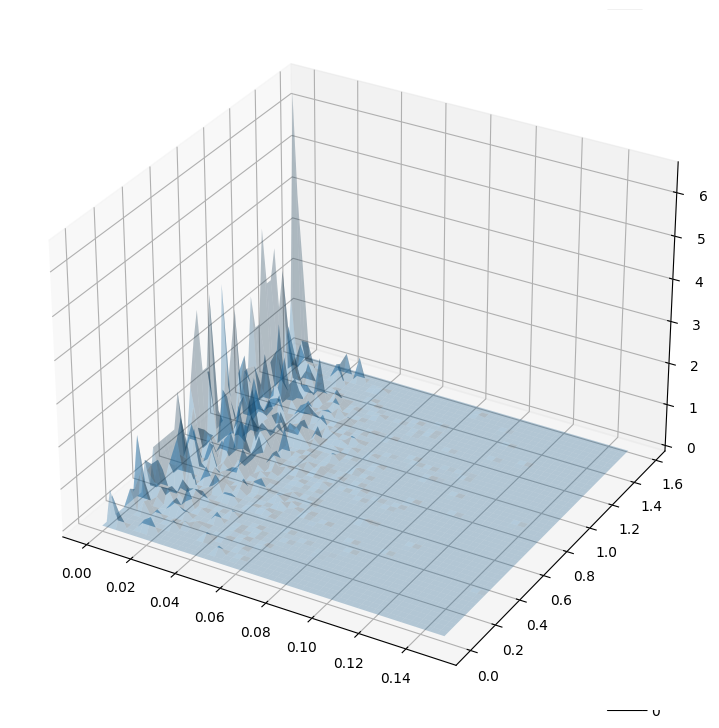

In [115]:
fig.delaxes(ax)
ax = fig.add_subplot(2, 2, 1, projection='3d')

R5, Alpha5 = np.meshgrid(R, Alpha)
ax.plot_surface(R5, Alpha5, RAlpha.T, alpha=0.3)

fig